# La prueba de cambio estructural de Chow

*Material del curso EC4301 Macroeconometría*

Universidad de Costa Rica

**Profesor:  Randall Romero Aguilar**

Actualizado: 2021-Jun-09

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import distributions

import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

plt.style.use('seaborn')

In [2]:
plt.rc('axes',labelsize=14, titlesize=16)
plt.rc('legend', fontsize=14, markerscale=1.5)
plt.rc('savefig', bbox='tight')
figpath ='../figures/'

In [3]:
gasdata = pd.read_csv('TableF2-2.txt', delim_whitespace=True)
gasdata['Year'] = gasdata['Year'].astype(int)
gasdata.index = pd.period_range(start=gasdata['Year'].iloc[0], end=gasdata['Year'].iloc[-1], freq='A')

In [4]:
gasdata.columns

Index(['Year', 'GasExp', 'Pop', 'Gasp', 'Income', 'PNC', 'PUC', 'PPT', 'PD',
       'PN', 'PS'],
      dtype='object')

In [5]:
series = {
    'GasExp' : 'Total U.S. gasoline expenditure',
    'Gasp' : 'Price index for gasoline', 
    'Income' : 'Per capita disposable income', 
    'PNC' : 'Price index for new cars', 
    'PUC' : 'Price index for used cars', 
    'PPT' : 'Price index for public transportation', 
    'PD' : 'Aggregate price index for consumer durables', 
    'PN' : 'Aggregate price index for consumer nondurables',
    'PS' : 'Aggregate price index for consumer services,',
    'Pop' : 'U.S. total population in thousands'}

In [6]:
samples = dict(todo = slice('1953','2004'),
               antes = slice('1953','1973'),
               despues = slice('1974','2004'))

In [7]:
gasdata.eval('G = GasExp/Gasp', inplace=True)
gasdata.eval('Gpc = 1e6*G/Pop', inplace=True)

gasdata['t'] = np.exp(gasdata['Year'] - 1952)

In [8]:
historic = pd.read_csv("crude-oil-prices.csv")
historic.index = pd.period_range(*historic['Year'].iloc[[0,-1]], freq='A')

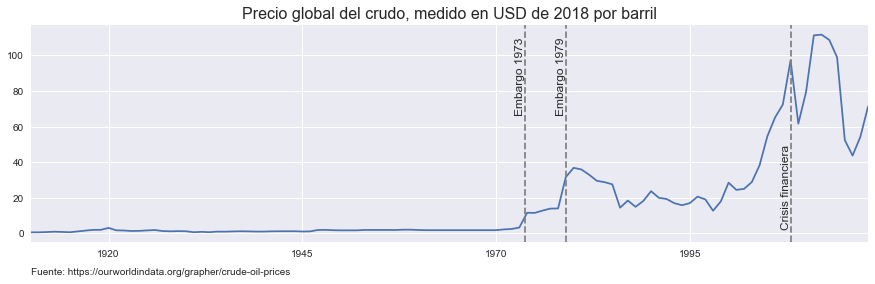

In [9]:
fig, ax = plt.subplots(figsize=[15,4])
historic['Oil - Crude prices since 1861 (US dollars per barrel)']['1910':].plot(ax = ax)
año = lambda yy: yy-1970

def anotar(yy, txt='', mes=1, pp=110):
    tt = año(yy) + (mes-1)/12
    ax.axvline(tt, ls='--', color='gray')
    ax.annotate(txt, (tt,pp), rotation=90, ha='right', va='top', size=12)

anotar(1973, 'Embargo 1973', 10)
anotar(1979, 'Embargo 1979')
anotar(2008, 'Crisis financiera', 1, pp=50)

ax.annotate('Fuente: https://ourworldindata.org/grapher/crude-oil-prices', [0,-0.15], xycoords='axes fraction')
ax.set_title('Precio global del crudo, medido en USD de 2018 por barril')
fig.savefig(figpath+'precio-petroleo.pdf')

In [10]:
historic.tail()

,Entity,Code,Year,Oil - Crude prices since 1861 (US dollars per barrel)
2014,World,OWID_WRL,2014,98.946008
2015,World,OWID_WRL,2015,52.386759
2016,World,OWID_WRL,2016,43.734170
2017,World,OWID_WRL,2017,54.192440
2018,World,OWID_WRL,2018,71.310060


In [11]:
gasdata.loc['1973',['Gpc','Gasp']]

Gpc      5.417616
Gasp    24.473000
Name: 1973, dtype: float64

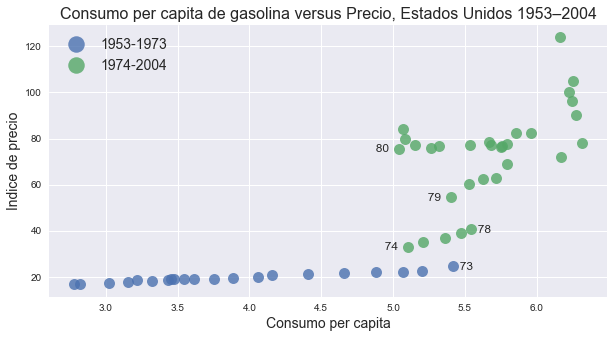

In [12]:
fig, ax = plt.subplots(figsize=[10,5])
ax.plot('Gpc', 'Gasp', 'o', data=gasdata[samples['antes']],label='1953-1973', markersize=11, alpha=50)
ax.plot('Gpc', 'Gasp', 'o', data=gasdata[samples['despues']], label='1974-2004', markersize=11, alpha=50)

ax.set(title='Consumo per capita de gasolina versus Precio, Estados Unidos 1953–2004',
      xlabel='Consumo per capita', ylabel='Indice de precio')


for yy, yyyy in zip([0,1,0,1,1], ['1973','1974','1978','1979','1980']):
    ha = 'right' if yy else 'left'  
    ax.annotate(f'  {yyyy[-2:]}   ', gasdata.loc[yyyy,['Gpc','Gasp']], va='center', ha=ha, size=12)



ax.legend();
fig.savefig(figpath+'mercado-gasolina.pdf')

In [13]:
S = dict()
params = dict()
signif = dict()

for periodo, ss in samples.items():
    mm = ols('Gpc ~ Income + Gasp + PNC + PUC + t', np.log(gasdata)[ss]).fit()
    S[periodo] =  mm.mse_resid * mm.df_resid
    params[periodo] = mm.params
    signif[periodo] = mm.pvalues < 0.05
    params[periodo]['$R^2$'] = mm.rsquared
    params[periodo]['S'] = S[periodo]
    print

In [14]:
resultados = pd.DataFrame(params).round(3)

for k, vals in zip([1,3,5], signif.values()):
    vals = vals.map(lambda x: '*' if x else ' ')
    vals['$R^2$'] = ' '
    vals['S'] = ' '
    resultados.insert(k, f'{k}', vals)

resultados.columns = ['todo' , ' ', 'antes', ' ', 'despues',' ']    

In [20]:
resultados.rename(index=dict(
    Intercept='intercepto', 
    Income='I', 
    Gasp='PG'),
                  columns=dict(
    todo='1953-2004', antes='1953-1973', despues='1974-2004'),
                  inplace=True)

resultados['descripción'] = ['intercepto', 'ingreso per capita','precio combustible',
                             'precio carro nuevo', 'precio carro usado','tendencia',
                             '$R^2$', 'suma residuos${}^2$']

resultados.to_latex(figpath+'gas-results-break.tex', escape=False, column_format='lrlrlrll')


In [16]:
T = gasdata.shape[0]
K = 6

chowstat = ((S['todo'] - S['antes'] - S['despues'])/K) / ((S['antes'] + S['despues'])/(T-2*K))

In [17]:
alpha = 0.05
fcritico= distributions.f(K,T-2*K).isf(alpha)

In [18]:
if chowstat >  fcritico:
    print(f'Hay evidencia de cambio estructural al {alpha*100:.1f}% de significancia')
    print(f'stat = {chowstat:.3f} > {fcritico:3f} = F({K},{T-2*K})')
else:
    print(f'No hay evidencia de cambio estructural al {alpha*100:.1f}% de significancia')

Hay evidencia de cambio estructural al 5.0% de significancia
stat = 67.645 > 2.335852 = F(6,40)


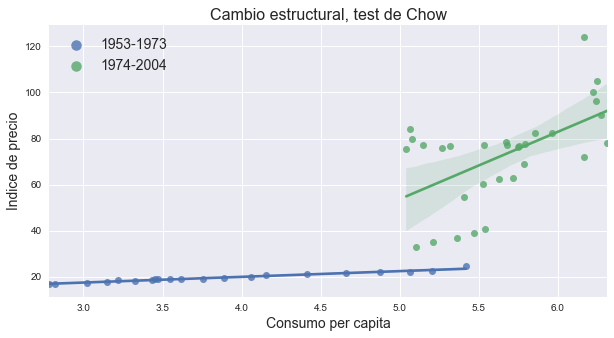

In [19]:
fig, ax = plt.subplots(figsize=[10,5])
sns.regplot(x='Gpc', y='Gasp', data=gasdata[samples['antes']],label='1953-1973', ax=ax)
sns.regplot(x='Gpc', y='Gasp', data=gasdata[samples['despues']], label='1974-2004',ax=ax)
ax.set(title='Cambio estructural, test de Chow',
      xlabel='Consumo per capita', ylabel='Indice de precio')
ax.legend(fontsize=14);


ttst = '$\\frac{\\frac{%.3f - %.3f - %.3f}{%d}}{\\frac{%.3f + %.3f}{%d - 2\\times %d}}$' % (S['todo'], S['antes'], S['despues'], K, S['antes'], S['despues'],T, K)
ttst += '$ = %.2f > %.2f$ = F(%d,%d)' % (chowstat, fcritico, K, T-2*K)

#f"$\\frac\{({S['todo']:.4f} - {S['antes']:.4f} - {S['despues']:.4f}\}{K}$ / ((S['antes'] + S['despues'])/(T-2*K))"
ax.annotate(ttst, (2.75,65), size=18)

fig.savefig(figpath+'mercado-gasolina-cambio-estructural.pdf')

